## Results Visualization

This notebook provides a visual analysis of the results from the benchmarking experiments.

#### Load Algorithm Results

In [ ]:
import pandas as pd
import glob
import os


# Path to results directory
results_dir = "results"

# Find all CSV files
csv_files = glob.glob(os.path.join(results_dir, "*.csv"))

# Parse each CSV as a DataFrame and add filename for traceability
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    df['filename'] = os.path.basename(file)
    dfs.append(df)

# Concatenate all results into one DataFrame
results_df = pd.concat(dfs, ignore_index=True)

# Display first few rows
print(results_df.head())

        Parameter            Value                             filename
0  Implementation  basic_multicast  basic_multicast_20250421-210502.csv
1            name         Low Rate  basic_multicast_20250421-210502.csv
2        duration               10  basic_multicast_20250421-210502.csv
3    message_rate               10  basic_multicast_20250421-210502.csv
4    message_size              100  basic_multicast_20250421-210502.csv


#### Clean and Structure Data

In [ ]:
# Pivot so each experiment is a row, columns are parameters
pivoted = results_df.pivot_table(index='filename', columns='Parameter', values='Value', aggfunc='first').reset_index()

# Extract the algorithm from the filename or from the 'Implementation' column
pivoted['algorithm'] = pivoted['Implementation'].fillna(pivoted['filename'].str.extract(r'(basic_multicast|jasper_multicast|dbo_multicast)')[0])

# Convert numeric columns to float
for col in ['Average Latency (ms)', 'Fairness Index', 'Bandwidth Efficiency (%)', 'duration', 'message_rate', 'message_size']:
    if col in pivoted.columns:
        pivoted[col] = pd.to_numeric(pivoted[col], errors='coerce')

print(pivoted.head())

Parameter                             filename  Average Latency (ms)  \
0          basic_multicast_20250421-210502.csv              1.275151   
1          basic_multicast_20250421-210505.csv              1.415234   
2          basic_multicast_20250421-210508.csv              1.523752   
3          basic_multicast_20250421-210511.csv              1.383326   
4          basic_multicast_20250421-211618.csv              1.762793   

Parameter  Bandwidth Efficiency (%) Delivery Clock Fairness  \
0                         67.338483                     NaN   
1                         72.990428                     NaN   
2                         67.361422                     NaN   
3                         67.607928                     NaN   
4                         72.601189                     NaN   

Parameter Delivery Clock Window (ms)  Fairness Index          Host  \
0                                NaN        0.986169  Latency (ms)   
1                                NaN        0.96

#### Group and Aggregate data by each algorithm (basic, jasper, dbo)

In [9]:
# Group by algorithm and message_rate, aggregate metrics
agg = pivoted.groupby(['algorithm', 'message_rate']).agg({
    'Average Latency (ms)': ['mean', 'std'],
    'Fairness Index': ['mean', 'std'],
    'Bandwidth Efficiency (%)': ['mean', 'std']
}).reset_index()

agg.columns = [
    'algorithm', 'message_rate',
    'latency_mean', 'latency_std',
    'fairness_mean', 'fairness_std',
    'bw_eff_mean', 'bw_eff_std'
]

# Display aggregated results
display(agg)


,algorithm,message_rate,latency_mean,latency_std,fairness_mean,fairness_std,bw_eff_mean,bw_eff_std
0,basic_multicast,10,1.493571,0.247767,0.939704,0.040778,67.690337,6.712814
1,basic_multicast,100,1.542355,0.172126,0.955478,0.020599,71.145205,3.989253
2,basic_multicast,200,1.387534,0.074957,0.946328,0.029324,70.863067,5.632319
3,dbo_multicast,10,1.510614,0.168274,0.967455,0.022703,90.926380,2.521734
4,dbo_multicast,100,1.526133,0.150553,0.978334,0.016098,91.238244,1.986415
5,dbo_multicast,200,1.475762,0.194848,0.973648,0.018733,89.754071,1.892202
6,jasper_multicast,10,1.211135,0.048263,0.994721,0.004443,84.022507,2.017123
7,jasper_multicast,100,1.187715,0.073715,0.996086,0.002643,82.424866,2.950355
8,jasper_multicast,200,1.201436,0.030257,0.994296,0.002485,85.910522,1.879907


#### Latency vs Message Rate Evaluation

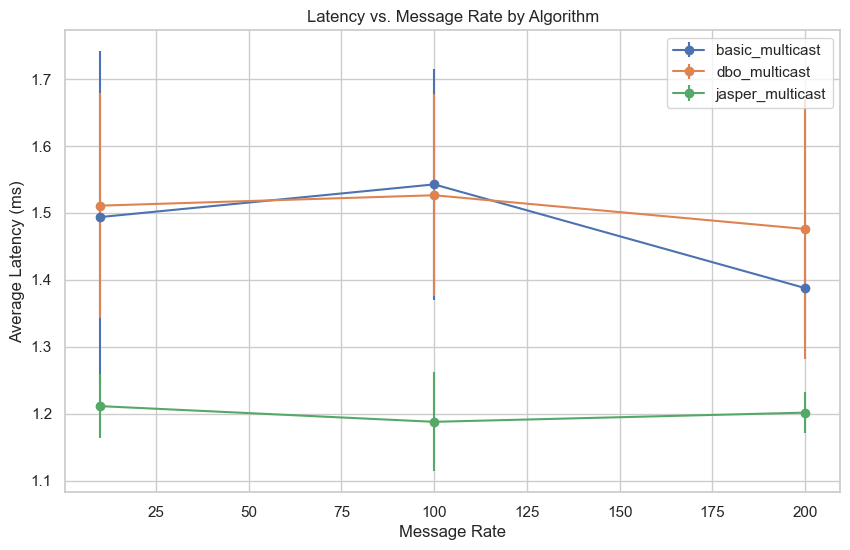

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for algo in agg['algorithm'].unique():
    subset = agg[agg['algorithm'] == algo]
    plt.errorbar(subset['message_rate'], subset['latency_mean'], yerr=subset['latency_std'], label=algo, marker='o')

plt.xlabel('Message Rate')
plt.ylabel('Average Latency (ms)')
plt.title('Latency vs. Message Rate by Algorithm')
plt.legend()
plt.show()

Lower latency indicates better performance. Jasper(green) is a clear winner in terms of latency performance metrics.

#### Fairness Index Evaluation

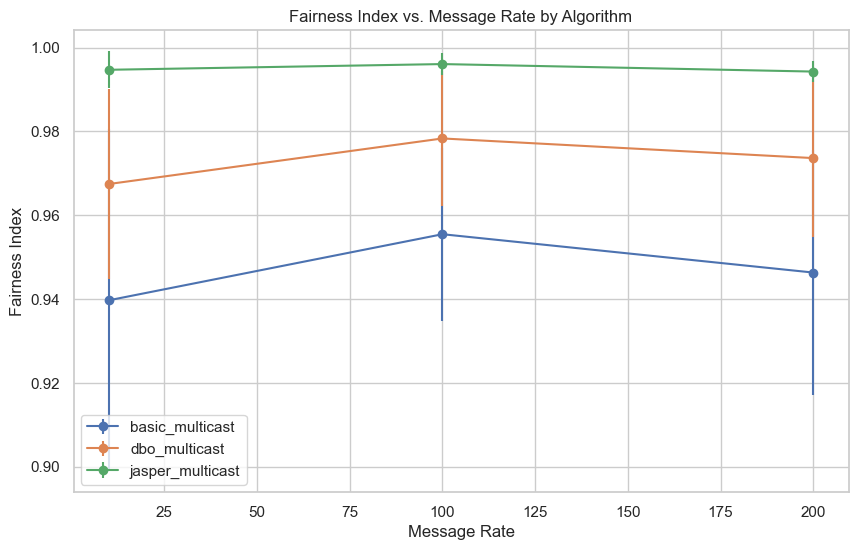

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for algo in agg['algorithm'].unique():
    subset = agg[agg['algorithm'] == algo]
    plt.errorbar(subset['message_rate'], subset['fairness_mean'], yerr=subset['fairness_std'], label=algo, marker='o')

plt.xlabel('Message Rate')
plt.ylabel('Fairness Index')
plt.title('Fairness Index vs. Message Rate by Algorithm')
plt.legend()
plt.grid(True)
plt.show()

Jasper shows higher delivery clock fairness than DBO and basic multicast. 

#### Bandwidth Efficiency Comparision

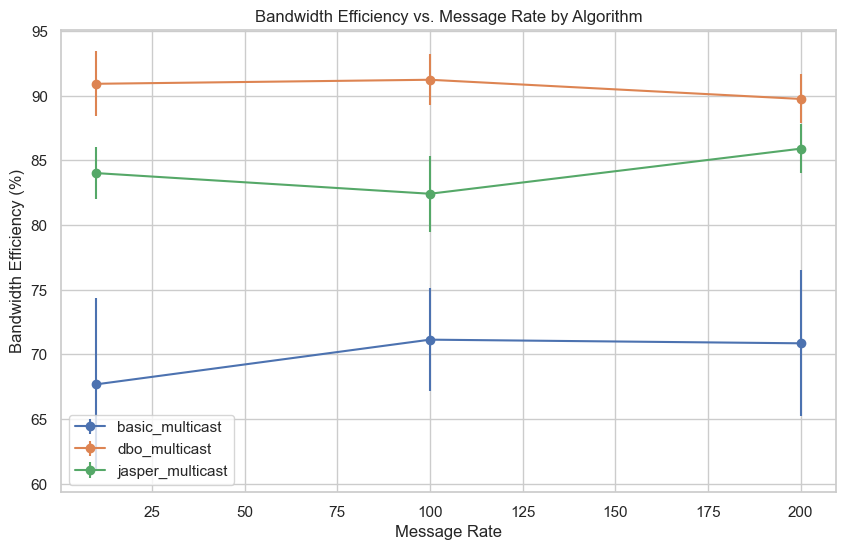

In [12]:
plt.figure(figsize=(10,6))
for algo in agg['algorithm'].unique():
    subset = agg[agg['algorithm'] == algo]
    plt.errorbar(subset['message_rate'], subset['bw_eff_mean'], yerr=subset['bw_eff_std'], label=algo, marker='o')

plt.xlabel('Message Rate')
plt.ylabel('Bandwidth Efficiency (%)')
plt.title('Bandwidth Efficiency vs. Message Rate by Algorithm')
plt.legend()
plt.grid(True)
plt.show()

DBO multicast shows better bandwidth efficiency, likely due to reduced overhead to synchronize clocks.

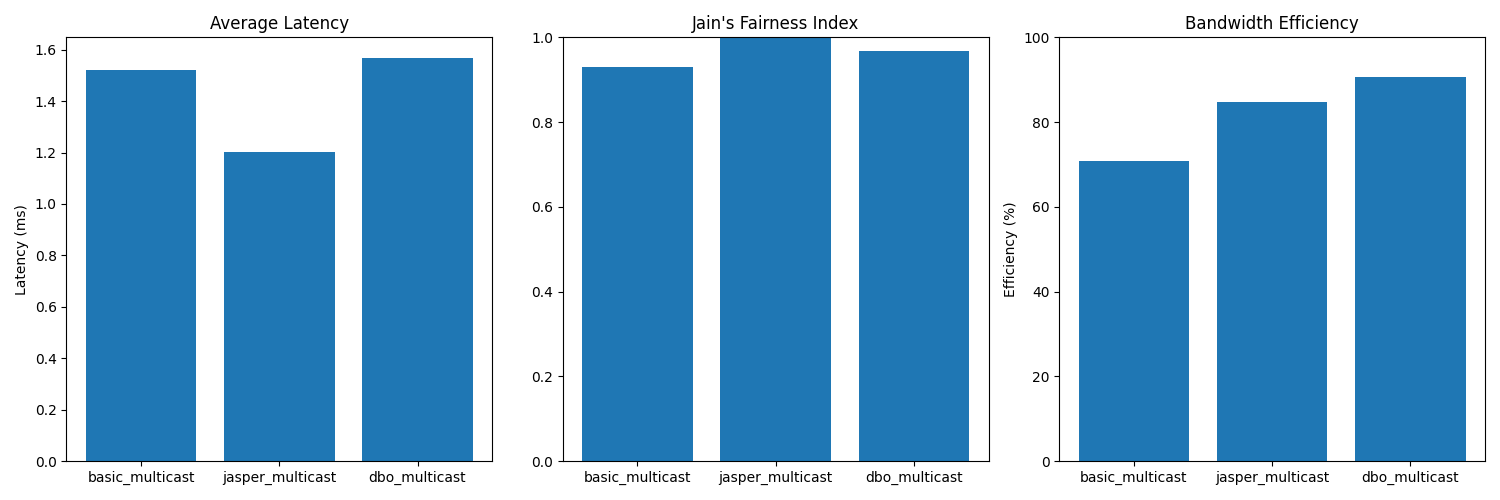

In [16]:
from IPython.display import Image, display

display(Image(filename='results/comparison_20250428-205030.png'))

Summarized results, Jasper is the overall winner, DBO is the second, basic(CloudEx) is the third.